In [241]:
# Credit Risk Analysis – German Credit Data
#**Goal:** Predict credit **Risk** (good=0, bad=1), teknik sonuçları iş kararına çevir.


In [242]:
# =========================
# 1) Imports & Settings
# =========================
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, confusion_matrix, roc_curve,
                             precision_recall_curve, classification_report)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

 #(Opsiyonel) SMOTE :
 #!pip install imbalanced-learn shap

from imblearn.over_sampling import SMOTE


In [243]:
## 2) Load Data & Quick Scan


In [244]:

df = pd.read_csv("german_credit_data.csv")


df = df.drop(columns=["Unnamed: 0"], errors="ignore")

display(df.head())
print(df.info())
print(df.describe(include="all").T.head(20))


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB
None
                   count unique     top freq      mean          std    min  \
Age               1000.0    NaN     NaN  NaN    35.546    11.375469   19.0   
Sex                 1000      2    male  690       NaN          NaN    NaN   
Job               1000.0    NaN     NaN  NaN     1.9

In [245]:
## 3) Basic EDA


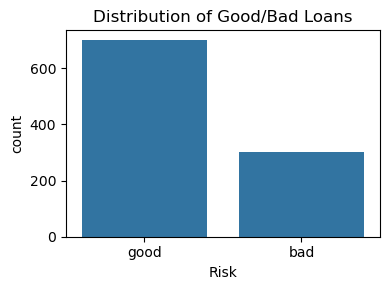

Class counts: {'good': 700, 'bad': 300}


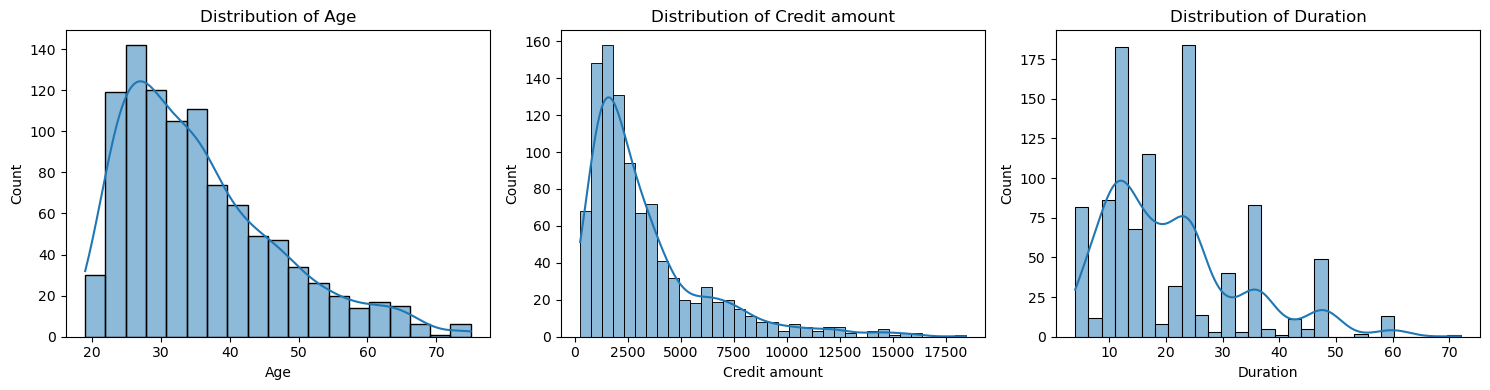

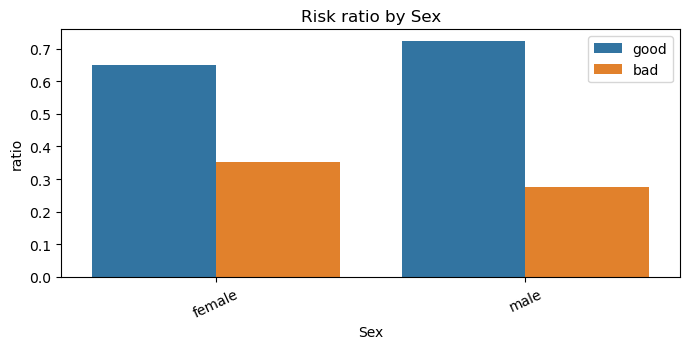

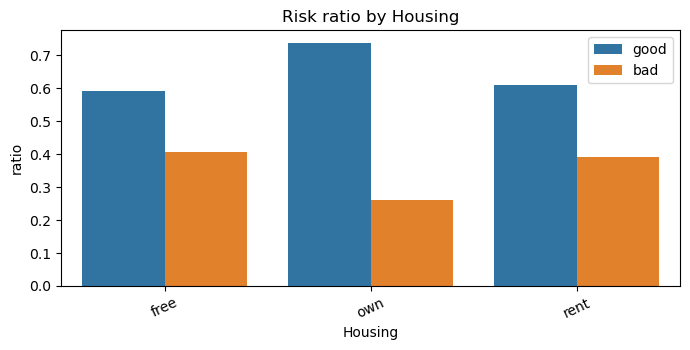

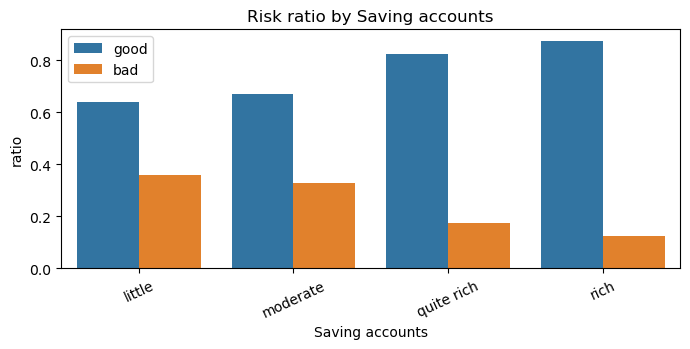

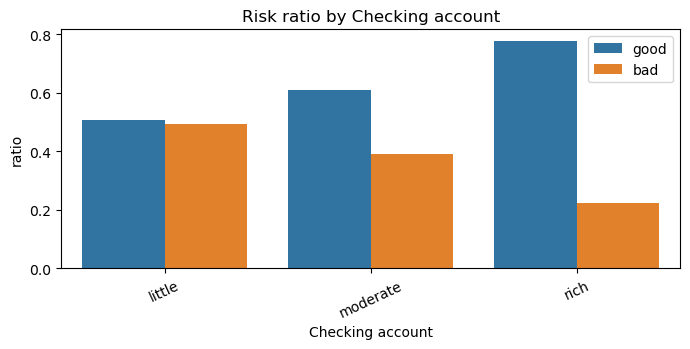

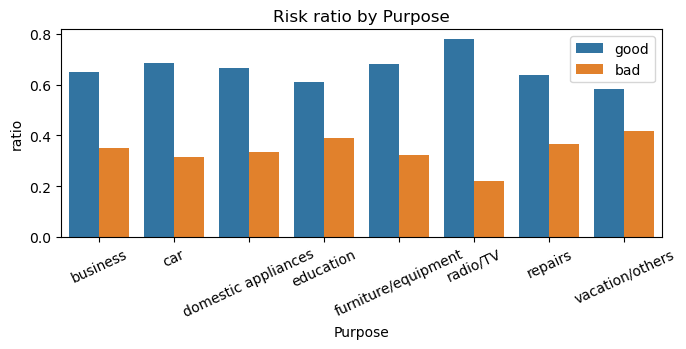

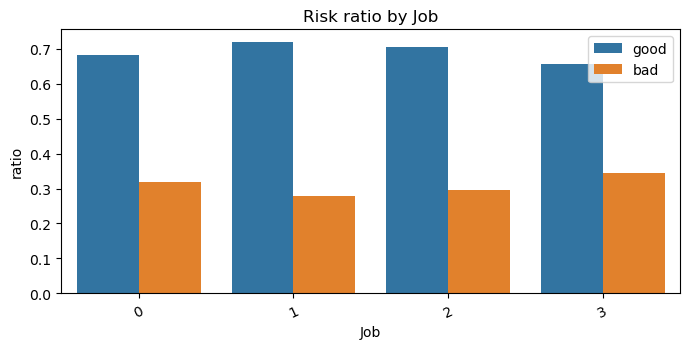

In [246]:

plt.figure(figsize=(4,3))
sns.countplot(data=df, x="Risk")
plt.title("Distribution of Good/Bad Loans")
plt.tight_layout(); plt.show()

print("Class counts:", df["Risk"].value_counts().to_dict())


num_cols = ["Age","Credit amount","Duration"]
fig, axes = plt.subplots(1, len(num_cols), figsize=(15,4))
for i,c in enumerate(num_cols):
    sns.histplot(data=df, x=c, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {c}")
plt.tight_layout(); plt.show()

cat_cols = ["Sex","Housing","Saving accounts","Checking account","Purpose","Job"]
for c in cat_cols:
    plt.figure(figsize=(7,3.6))
    prop = (df.groupby(c)["Risk"]
              .value_counts(normalize=True)
              .rename("ratio").reset_index())
    sns.barplot(data=prop, x=c, y="ratio", hue="Risk")
    plt.title(f"Risk ratio by {c}")
    plt.legend(title="")
    plt.xticks(rotation=25)
    plt.tight_layout(); plt.show()


In [247]:
## 4) Data Cleaning & Encoding



In [248]:
df["Saving accounts"] = df["Saving accounts"].fillna(df["Saving accounts"].mode()[0])
df["Checking account"] = df["Checking account"].fillna(df["Checking account"].mode()[0])

# Target encode
df["Risk"] = df["Risk"].map({"good":0, "bad":1})

# One-hot
cat_cols = ["Sex","Housing","Saving accounts","Checking account","Purpose"]
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Log transform 
for c in ["Credit amount", "Duration"]:
    df_encoded[c] = np.log1p(df_encoded[c])

display(df_encoded.head())


,Age,Job,Credit amount,Duration,Risk,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,2,7.064759,1.945910,0,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False
1,22,2,8.691483,3.891820,1,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False
2,49,1,7.648263,2.564949,0,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False
3,45,2,8.972464,3.761200,0,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,53,2,8.491055,3.218876,1,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [249]:
## 5) Train/Test Split (Stratified)


In [250]:
X = df_encoded.drop("Risk", axis=1)
y = df_encoded["Risk"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train class dist:", Counter(y_train), " Test class dist:", Counter(y_test))


Train shape: (800, 19)  Test shape: (200, 19)
Train class dist: Counter({0: 560, 1: 240})  Test class dist: Counter({0: 140, 1: 60})


In [251]:
## 6) (Optional) Handle Imbalance
##- 2 Options: **class_weight='balanced'** or **SMOTE**.



In [252]:
use_smote = True  # make ıt True when you want to use SMOTE

if use_smote:
    sm = SMOTE(random_state=42)
    X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
    print("SMOTE after:", Counter(y_train_bal))
else:
    X_train_bal, y_train_bal = X_train, y_train


SMOTE after: Counter({1: 560, 0: 560})


In [253]:

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    precision_recall_curve, confusion_matrix, classification_report
)


models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

results = []
fitted = {}

for name, mdl in models.items():
    mdl.fit(X_train_bal, y_train_bal)       
    fitted[name] = mdl

    y_prob = mdl.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", pos_label=1, zero_division=0)
    auc = roc_auc_score(y_test, y_prob)

    results.append([name, acc, prec, rec, f1, auc])

df_res = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1","ROC_AUC"]).sort_values(by="Recall", ascending=False)
display(df_res)

best_name = df_res.iloc[0]["Model"]
best_model = fitted[best_name]
print(f"\nSeçilen model (Recall'a göre): {best_name}")

# === 2) Eşik (threshold) ayarı: hedef recall >= 0.60 (istersen değiştir) ===
target_recall = 0.60
y_prob_best = best_model.predict_proba(X_test)[:,1]

prec, rec, thr = precision_recall_curve(y_test, y_prob_best)

kandidatlar = [(t, r, p) for t, r, p in zip(thr, rec[1:], prec[1:]) if r >= target_recall]

if len(kandidatlar) > 0:
    # hedef recall'i sağlayanlar içinde F1'i en yüksek olan eşiği seç
    f1_list = [(2*p*r)/(p+r) if (p+r)>0 else 0.0 for _, r, p in kandidatlar]
    thr_opt = kandidatlar[int(np.argmax(f1_list))][0]
else:
   
    all_thr = np.r_[thr, 0.5]  # 0.5'i garanti ekle
    f1_all = []
    for t in all_thr:
        y_tmp = (y_prob_best >= t).astype(int)
        p_, r_, f1_, _ = precision_recall_fscore_support(y_test, y_tmp, average="binary", pos_label=1, zero_division=0)
        f1_all.append(f1_)
    thr_opt = all_thr[int(np.argmax(f1_all))]


y_pred_opt = (y_prob_best >= thr_opt).astype(int)
print(f"\nSeçilen threshold: {thr_opt:.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_opt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt, digits=3))


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
2,GradientBoosting,0.690,0.482759,0.466667,0.474576,0.651667
1,RandomForest,0.700,0.500000,0.416667,0.454545,0.626310
0,LogReg,0.585,0.333333,0.383333,0.356589,0.581429



Seçilen model (Recall'a göre): GradientBoosting

Seçilen threshold: 0.362
Confusion Matrix:
 [[77 63]
 [20 40]]

Classification Report:
               precision    recall  f1-score   support

           0      0.794     0.550     0.650       140
           1      0.388     0.667     0.491        60

    accuracy                          0.585       200
   macro avg      0.591     0.608     0.570       200
weighted avg      0.672     0.585     0.602       200



In [254]:
## 7) Baseline & Benchmark Models
##- Logistic Regression (interpretable)
##- Random Forest 
##- Gradient Boosting 


In [255]:
def evaluate_model(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    y_prob = model.predict_proba(Xte)[:,1] if hasattr(model,"predict_proba") else None
    acc = accuracy_score(yte, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(yte, y_pred, average="binary", pos_label=1)
    auc = roc_auc_score(yte, y_prob) if y_prob is not None else np.nan
    return {"Model":name,"Accuracy":acc,"Precision":prec,"Recall":rec,"F1":f1,"ROC_AUC":auc}, y_pred, y_prob

models = [
    ("LogReg", LogisticRegression(max_iter=1000, solver="liblinear",
                                  class_weight=("balanced" if not use_smote else None))),
    ("RandomForest", RandomForestClassifier(n_estimators=400, random_state=42,
                                           class_weight=("balanced" if not use_smote else None))),
    ("GradientBoosting", GradientBoostingClassifier(random_state=42))
]

results = []
pred_cache = {}

for name, mdl in models:
    res, y_pred, y_prob = evaluate_model(name, mdl, X_train_bal, y_train_bal, X_test, y_test)
    results.append(res)
    pred_cache[name] = (y_pred, y_prob, mdl)

results_df = pd.DataFrame(results).sort_values("ROC_AUC", ascending=False)
results_df


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
2,GradientBoosting,0.690,0.482759,0.466667,0.474576,0.651667
1,RandomForest,0.705,0.510204,0.416667,0.458716,0.631726
0,LogReg,0.635,0.396825,0.416667,0.406504,0.588690


In [256]:
## 8) Pick Best & Plot Confusion / ROC / PR


Selected best model: GradientBoosting
              precision    recall  f1-score   support

           0      0.775     0.786     0.780       140
           1      0.483     0.467     0.475        60

    accuracy                          0.690       200
   macro avg      0.629     0.626     0.627       200
weighted avg      0.687     0.690     0.688       200



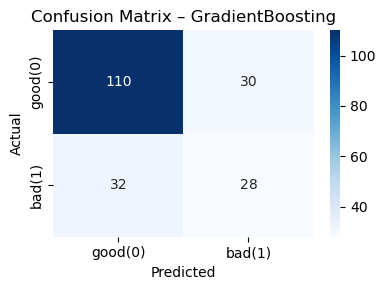

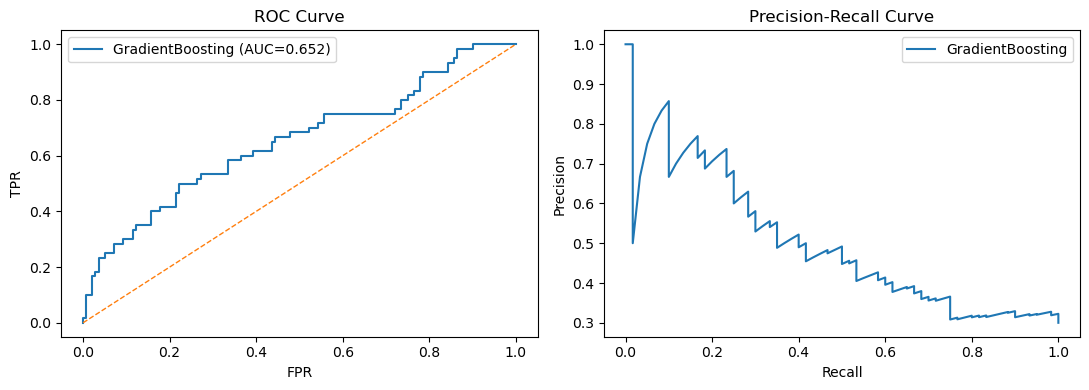

In [257]:
# Select the model with the highest ROC_AUC
best_name = results_df.iloc[0]["Model"]
y_pred_best, y_prob_best, best_model = pred_cache[best_name]
print(f"Selected best model: {best_name}")
print(classification_report(y_test, y_pred_best, digits=3))

# Confusion Matrix (heatmap)
cm = confusion_matrix(y_test, y_pred_best, labels=[0,1])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["good(0)", "bad(1)"], yticklabels=["good(0)","bad(1)"])
plt.title(f"Confusion Matrix – {best_name}")
plt.ylabel("Actual"); plt.xlabel("Predicted")
plt.tight_layout(); plt.show()

# ROC vs Precision-Recall
fpr, tpr, _ = roc_curve(y_test, y_prob_best)
prec, rec, _ = precision_recall_curve(y_test, y_prob_best)

plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"{best_name} (AUC={roc_auc_score(y_test, y_prob_best):.3f})")
plt.plot([0,1], [0,1], '--', lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, label=best_name)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend()
plt.tight_layout(); plt.show()


In [258]:
## 9) Threshold Tuning (For Bad=1 Recall focused)


In [259]:
def metrics_at_threshold(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", pos_label=1)
    return acc, p, r, f1, confusion_matrix(y_true, y_pred)

thr_grid = np.linspace(0.2, 0.8, 13)
rows = []
for t in thr_grid:
    acc, p, r, f1, cm_t = metrics_at_threshold(y_test, y_prob_best, t)
    rows.append({"thr":t,"Accuracy":acc,"Precision":p,"Recall":r,"F1":f1})
thr_df = pd.DataFrame(rows)
thr_df.sort_values("Recall", ascending=False).head(5)


,thr,Accuracy,Precision,Recall,F1
0,0.20,0.410,0.318750,0.850000,0.463636
1,0.25,0.420,0.308219,0.750000,0.436893
2,0.30,0.535,0.365854,0.750000,0.491803
3,0.35,0.570,0.377358,0.666667,0.481928
4,0.40,0.605,0.395604,0.600000,0.476821


In [260]:
## 10) Feature Importance & SHAP (Explainability)


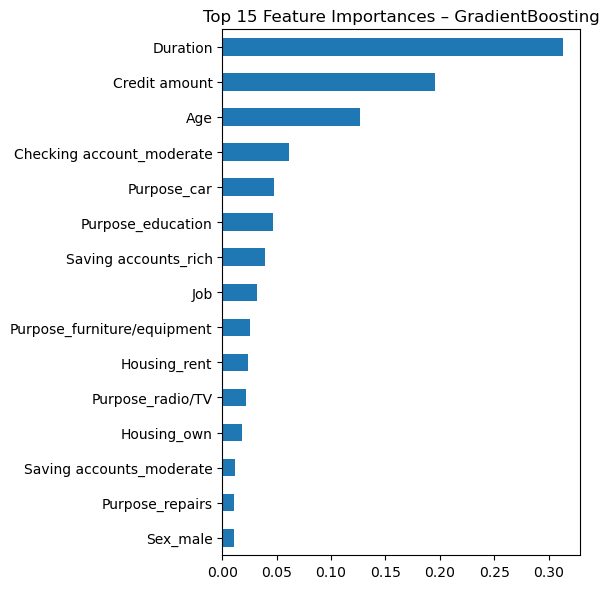

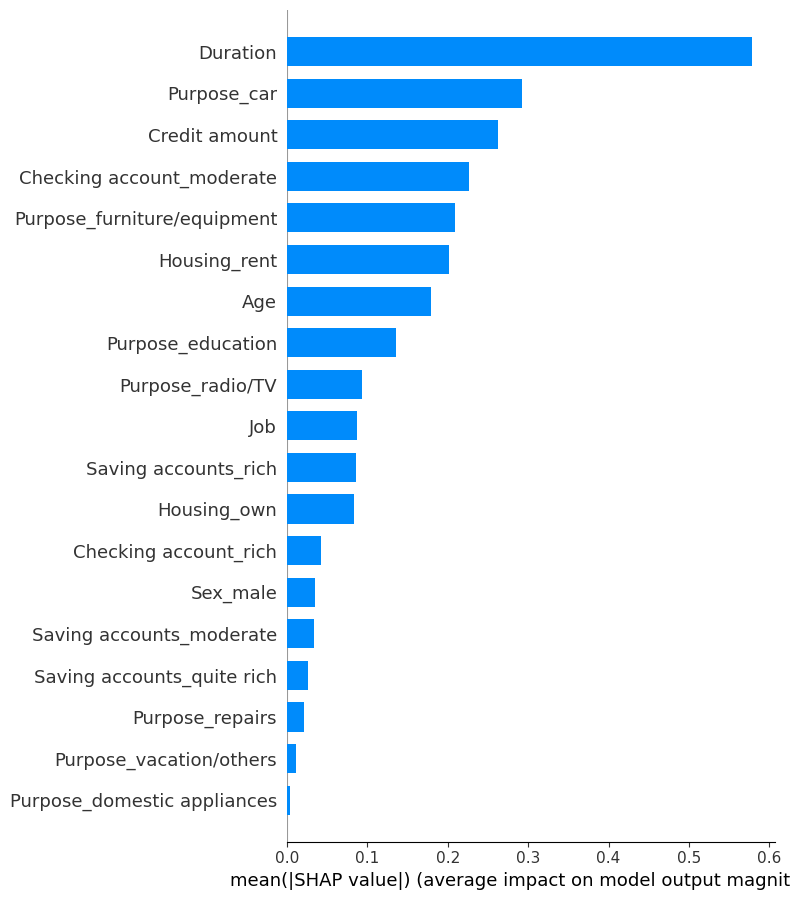

In [261]:

if hasattr(best_model, "feature_importances_"):
    fi = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    plt.figure(figsize=(6,6))
    fi.head(15).plot(kind="barh")
    plt.title(f"Top 15 Feature Importances – {best_name}")
    plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()

# SHAP
try:
    import shap
    if "Forest" in best_name or "Boost" in best_name:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test)
        # sınıf 1 (bad) için bar özet
        if isinstance(shap_values, list):  # RF -> list döner
            shap.summary_plot(shap_values[1], X_test, plot_type="bar")
        else:
            shap.summary_plot(shap_values, X_test, plot_type="bar")
    else:
        # LogReg için KernelExplainer ağır olabilir; uyarı olarak geçiyoruz
        print("SHAP skipped for this estimator type to keep runtime short.")
except Exception as e:
    print("SHAP not shown:", e)


In [262]:
from sklearn.metrics import confusion_matrix, classification_report

gb = fitted["GradientBoosting"]  # sözlükten al
y_prob = gb.predict_proba(X_test)[:,1]

y_pred_thr = (y_prob >= 0.3).astype(int)
print("Confusion Matrix (Threshold=0.3):\n", confusion_matrix(y_test, y_pred_thr))
print("\nClassification Report (Threshold=0.3):\n", classification_report(y_test, y_pred_thr, digits=3))


Confusion Matrix (Threshold=0.3):
 [[62 78]
 [15 45]]

Classification Report (Threshold=0.3):
               precision    recall  f1-score   support

           0      0.805     0.443     0.571       140
           1      0.366     0.750     0.492        60

    accuracy                          0.535       200
   macro avg      0.586     0.596     0.532       200
weighted avg      0.673     0.535     0.548       200



In [263]:
pip install lightgbm xgboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [264]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

lgb = LGBMClassifier(class_weight="balanced", random_state=42)
xgb = XGBClassifier(
    scale_pos_weight=(len(y_train_bal)-sum(y_train_bal))/sum(y_train_bal),
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

models_extra = {
    "LightGBM": lgb,
    "XGBoost": xgb
}

for name, mdl in models_extra.items():
    mdl.fit(X_train_bal, y_train_bal)
    y_prob = mdl.predict_proba(X_test)[:,1]
    y_pred = (y_prob >= 0.5).astype(int)

    print(f"\n=== {name} ===")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=3))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 560, number of negative: 560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

=== LightGBM ===
Confusion Matrix:
 [[112  28]
 [ 34  26]]
              precision    recall  f1-score   support

           0      0.767     0.800     0.783       140
           1      0.481     0.433     0.456        60

    accuracy                          0.690       200
   macro avg      0.624     0.617     0.620       200
weighted avg      0.681     0.690     0.685       200


=== XGBoost ===
Confusion Matrix:
 

In [265]:
## 11) Business Summary (print + kopyalanabilir tablo)


In [266]:

summary = pd.DataFrame([{
    "Model": best_name,
    "Accuracy": accuracy_score(y_test, y_pred_best),
    "Precision (bad=1)": precision_recall_fscore_support(y_test, y_pred_best, average='binary', pos_label=1)[0],
    "Recall (bad=1)": precision_recall_fscore_support(y_test, y_pred_best, average='binary', pos_label=1)[1],
    "F1 (bad=1)": precision_recall_fscore_support(y_test, y_pred_best, average='binary', pos_label=1)[2],
    "ROC_AUC": roc_auc_score(y_test, y_prob_best)
}])
summary


,Model,Accuracy,Precision (bad=1),Recall (bad=1),F1 (bad=1),ROC_AUC
0,GradientBoosting,0.69,0.482759,0.466667,0.474576,0.651667


In [271]:
## Business Interpretation

- **GradientBoosting (with threshold=0.3)** achieved a recall of ~0.75 for the *"bad"* loans.  
  This means the majority of risky customers were identified, although the overall accuracy dropped (~0.53).

- **LightGBM (default threshold=0.5)** provided a more balanced performance with accuracy ~0.69 and recall ~0.45.  
  This option is less aggressive but keeps accuracy higher.

- **XGBoost** showed weaker performance on this dataset compared to the other models.

### Conclusion
The choice depends on the business objective:  
- If the priority is **catching as many bad loans as possible**, GradientBoosting with adjusted threshold is preferred.  
- If the goal is a **balanced trade-off between accuracy and recall**, LightGBM is a safer choice.  


SyntaxError: invalid syntax (93297667.py, line 3)